In [2]:
import glob
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [192]:
class dataset:

    def _get_dir_list(self, path):
        return glob.glob(path)

    def _get_file_list_in_dir(self, d):
        f = glob.glob(d + '/*.csv')
        f.sort()
        return f

    def _get_df_from_csv(self, f):
        is_iOS = "iphone" in f
        df = pd.read_csv(f)

        if is_iOS:
            # rename column name to integrate
            df.rename(columns={'rssi': 'remote_rssi'}, inplace=True)
            # remove unsaved parameters
            del df['magneticField.accuracy']
            del df['magneticField.field.x']
            del df['magneticField.field.y']
            del df['magneticField.field.z']
        else:
            # rename column name to integrate
            df.rename(columns={'rssi(A)': 'rssi.a'}, inplace=True)
            df.rename(columns={'rssi(B)': 'rssi.b'}, inplace=True)
            # remove unsaved parameters
            del df['temperature']
            del df['humidity']
            del df['proximity']

        # remove data while rssi is not recorded
        buf = np.where(df['rssi.a'].as_matrix() != -1)[0]
        if len(buf) == 0:
            print('x', end='')
            return None
        first_rssi_idx = buf[0]
        df = df.ix[first_rssi_idx:, :]

        # adjust the value of button pushed data 
        df.loc[df['btn_push'] == -1, 'btn_push'] = 0

        # convert -1 to NaN
        df[df == -1] = np.nan

        # interpolate NaN
        df = df.apply(pd.Series.interpolate)

        print('.', end='')

        return df

    def __init__(self, path='data/raw/*_*_0[1-4]*'):
        self.path = path
        d = self._get_dir_list(path)
        title = [os.path.basename(_d) for _d in d]

        r = []
        for _d in d[:2]:
            print(_d)
            title = os.path.basename(_d)
            file_list = self._get_file_list_in_dir(_d)
            fname_list = [os.path.basename(_f) for _f in file_list]
            df_list = [self._get_df_from_csv(f) for f in file_list]
            print('')
            r.extend([[title, fn, df] for (fn, df) in zip(fname_list, df_list)])

        self.df_master = pd.DataFrame(r, columns=('title', 'fname', 'dataframe'))
    
    def _time_range_around_button_push(self, df, before=0, after=0):
        t = df[df['btn_push'] == 1].index
        point = t[0] if len(t) > 0 else df.index[-1] - 150
        return df.loc[(point - before):(point + after)]

    def get_data(self, title='.*', fname='.*', before=None, after=0, column=None):
        # extract the [title, fname, dataframe]
        dfm = self.df_master[self.df_master['title'].str.contains(title)]
        dfm = dfm[dfm['fname'].str.contains(fname)]
        # to list of dataframe
        dfml = [d for d in dfm['dataframe'].tolist() if d is not None]
        # limit the time range
        dfml = [self._time_range_around_button_push(d, before, after) for d in dfml]
        # limit the column
        if column != None: dfml = [d[column] for d in dfml]
        print("extracted %d dataframes" % (len(dfml)))
        return dfml

In [233]:
ds = dataset()
ds.df_master[ds.df_master['title'] == '01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅']['dataframe'][0].head()

data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅
...x..........................
data/raw/02_03_03_4F実験室_iphone_カバン_裏上_異常_まっすぐ帰宅
..............................


,date,rssi.a,rssi.b,remote_rssi,linear_accel[0],linear_accel[1],linear_accel[2],accelerometer[0],accelerometer[1],accelerometer[2],...,game_rotation[0],game_rotation[1],game_rotation[2],game_rotation[3],magnetic[0],magnetic[1],magnetic[2],pressure,light,btn_push
91,2017/04/06 14:22:23.334,-62.000000,-62.000000,-81.0,0.107452,0.013687,-0.266391,0.587601,2.197723,9.080734,...,0.096745,0.062251,0.681178,0.723023,18.890984,3.055763,-18.236160,NaN,NaN,0.0
92,2017/04/06 14:22:23.354,-66.333333,-63.428571,-81.0,0.149785,0.028881,-0.196661,0.700928,2.234436,9.088989,...,0.096946,0.062199,0.681327,0.722859,18.890984,3.055763,-18.324090,1017.940550,NaN,0.0
93,2017/04/06 14:22:23.376,-70.666667,-64.857143,-81.0,0.192119,0.044076,-0.126932,0.554733,2.217590,9.249832,...,0.097190,0.061880,0.681452,0.722737,18.709404,3.328323,-18.412018,1017.945525,NaN,0.0
94,2017/04/06 14:22:23.395,-75.000000,-66.285714,-72.0,-0.086707,0.132139,0.141152,0.397614,2.316269,9.463730,...,0.097190,0.061788,0.681132,0.723046,18.709404,3.419304,-18.587875,1017.950500,110.0,0.0
95,2017/04/06 14:22:23.415,-70.500000,-67.714286,-72.0,-0.023780,0.118709,0.021171,0.336319,2.278671,9.353012,...,0.097196,0.062068,0.681002,0.723144,18.709404,3.328514,-18.412018,1017.950500,109.5,0.0


In [231]:
ds.df_master.iloc[0]['dataframe'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 175 to 746
Data columns (total 31 columns):
date                572 non-null object
rssi.a              572 non-null float64
rssi.b              572 non-null float64
remote_rssi         572 non-null float64
linear_accel[0]     572 non-null float64
linear_accel[1]     572 non-null float64
linear_accel[2]     572 non-null float64
accelerometer[0]    572 non-null float64
accelerometer[1]    572 non-null float64
accelerometer[2]    572 non-null float64
gravity[0]          572 non-null float64
gravity[1]          572 non-null float64
gravity[2]          572 non-null float64
gyro[0]             572 non-null float64
gyro[1]             572 non-null float64
gyro[2]             572 non-null float64
rotation[0]         572 non-null float64
rotation[1]         572 non-null float64
rotation[2]         572 non-null float64
rotation[3]         572 non-null float64
rotation[4]         572 non-null float64
game_rotation[0]    572 non-null 

In [240]:
d = ds.get_data('01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅', before=6, after=2, column=['rssi.b','rssi.a','linear_accel[0]','btn_push'])[0]
d.values

extracted 29 dataframes


array([[ -4.50000000e+01,  -3.80000000e+01,   2.31796260e-01,
          0.00000000e+00],
       [ -4.50000000e+01,  -3.90000000e+01,   4.49132920e-02,
          0.00000000e+00],
       [ -4.50000000e+01,  -3.95000000e+01,  -5.70392600e-02,
          0.00000000e+00],
       [ -4.55000000e+01,  -4.00000000e+01,  -1.44490240e-01,
          0.00000000e+00],
       [ -4.60000000e+01,  -4.10000000e+01,  -4.98676300e-02,
          0.00000000e+00],
       [ -4.80000000e+01,  -4.20000000e+01,   1.06868744e-01,
          0.00000000e+00],
       [ -5.00000000e+01,  -4.05000000e+01,   2.66572000e-01,
          1.00000000e+00],
       [ -5.00000000e+01,  -3.90000000e+01,   2.57425300e-01,
          0.00000000e+00],
       [ -5.00000000e+01,  -4.05000000e+01,   3.09682850e-01,
          0.00000000e+00]])

extracted 29 dataframes


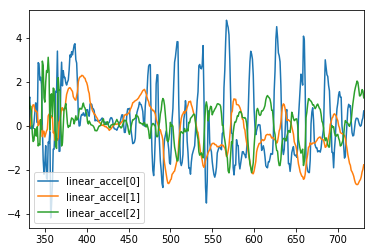

In [241]:
df = ds.get_data(title='01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅', before=400, after=0, column=['linear_accel[0]','linear_accel[1]','linear_accel[2]'])[3]
df.plot()

In [199]:
# sample for data ananlysis
ds = dataset('data/raw/01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅')

data/raw/01_01_01_4F実験室_XperiaZ3_胸ポケット_裏上_正常_まっすぐ帰宅
..............................


In [247]:
dfl = ds.get_data(title='01_01_02_4F実験室_XperiaZ3_カバン_裏上_正常_まっすぐ帰宅',
                 before=5, after=0, column=['linear_accel[0]','linear_accel[1]','linear_accel[2]'])[:4]
#normal = [df.as_matrix().reshape(-1) for df in dfl]
#normal

def _get_data(dfm, title='.*', fname='.*', before=0, after=0, column=None):
    # extract the [title, fname, dataframe]
    dfm = self.df_master[self.df_master['title'].str.contains(title)]
    dfm = dfm[dfm['fname'].str.contains(fname)]
    # to list of dataframe
    dfml = [d for d in dfm['dataframe'].tolist() if d is not None]
    # limit the time range
    dfml = [self._time_range_around_button_push(d, before, after) for d in dfml]
    # limit the column
    if column != None: dfml = [d[column] for d in dfml]
    print("extracted %d dataframes" % (len(dfml)))
    return dfml
df = dfl[0]
df

extracted 29 dataframes


,linear_accel[0],linear_accel[1],linear_accel[2]
693,0.044913,-1.579473,0.463062
694,-0.057039,-1.348034,0.487368
695,-0.144490,-1.167390,0.478381
696,-0.049868,-0.897218,0.383633
697,0.106869,-0.743984,0.294303
698,0.266572,-0.615294,0.187120


In [256]:
(2*df['linear_accel[0]'] + df['linear_accel[1]']).std()

0.58730733561568127

In [223]:
########################## k-NN 
from sklearn.neighbors import NearestNeighbors
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
X = normal
nbrs = NearestNeighbors(n_neighbors=3, algorithm='ball_tree')
nbrs.fit(X)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [224]:
distances, indices = nbrs.kneighbors(X)
print(distances)
print(indices)

[[ 0.          0.96900979  1.18613318]
 [ 0.          0.47547992  0.56683676]
 [ 0.          0.95248595  0.97963222]
 [ 0.          0.70762178  0.87519611]
 [ 0.          0.62291934  0.73165756]
 [ 0.          0.62291934  0.96900979]
 [ 0.          0.99479435  1.00146631]
 [ 0.          0.56683676  0.6744973 ]
 [ 0.          0.7166177   0.80090115]
 [ 0.          0.47547992  0.6744973 ]]
[[0 5 4]
 [1 9 7]
 [2 9 8]
 [3 7 1]
 [4 5 1]
 [5 4 0]
 [6 5 4]
 [7 1 9]
 [8 7 1]
 [9 1 7]]
